In [1]:
import nbpresent
nbpresent.__version__

'3.0.2'

In [3]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Figures for HUJI - ETH meeting

In [4]:
## FMcMillen model functions

import numpy
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmath import sqrt
import time 
from lmfit import Parameters, minimize, fit_report
import scipy.io
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

%matplotlib inline

def FermiDirac(E,T):
    return numpy.array(1 / (1 + numpy.exp(E / T)))

def SelfConsEq(Delta,E,Delta0,Gamma):
    if Delta[0].imag > 0:
        Delta[0] = Delta[0].conjugate()
    if Delta[1].imag > 0:
        Delta[1] = Delta[1].conjugate()

    NewDelta = numpy.ndarray(2,complex)
    NewDelta[0] = (Delta0[0] + Gamma[0] * Delta[1] / sqrt(Delta[1]**2 - E**2))/ \
         (1  + Gamma[0] / sqrt(Delta[1] ** 2 - E ** 2))
    NewDelta[1] = (Delta0[1] + Gamma[1] * Delta[0] / sqrt(Delta[0]**2 - E**2))/ \
         (1  + Gamma[1] / sqrt(Delta[0] ** 2 - E ** 2))

    return NewDelta

def Iterations(prevDelta,E,Delta0,Gamma):
    errors = numpy.array([1,1])
    index = 0
    prevDelta = prevDelta + 0.1*1j
    while (max(abs(errors))> 1e-6 ) and (index < 1e1):
        index = index+1
        newDelta = SelfConsEq(prevDelta,E,Delta0,Gamma)
        errors = prevDelta - newDelta
        prevDelta = newDelta
    return newDelta, errors

def CalculateDOS(Energys,Delta0,Gamma,Neff):
    
    Neff = numpy.array(Neff)
    Gamma = numpy.array(Gamma)
    Delta0 = numpy.array(Delta0)
    Energys = numpy.array(Energys)
    
    initDelta = numpy.array([0.5-0.1*1j, 0 + 0.1*1j])
    sol , err = Iterations(initDelta,0,Delta0,Gamma)
    
    Ns = [0]*(len(Energys))
    Deltas = [0]*(len(Energys))
    errors = [0]*(len(Energys))
    N = numpy.ndarray(len(Energys))
    
    for k in range(len(Energys)):
        initDelta = sol
        sol , err = Iterations(initDelta,Energys[k],Delta0,Gamma)
        Deltas[k] = sol
        errors[k] = err
        Ns[k] = Neff * (Energys[k]/(Energys[k]**2 - sol**2 )**0.5).real
        N[k] = sum(Ns[k])
   
    return N

def IofV(Vs,Delta0,Gamma,Neff,T):
    energys = numpy.linspace(0,6,1000)
    N = CalculateDOS(energys,Delta0,Gamma,Neff)
    
    energys = numpy.concatenate([numpy.flipud(-energys),energys])
    N = numpy.concatenate([numpy.flipud(N),N])
    N = N/N[0]
    

    Is = numpy.ndarray(len(Vs))


    FDS = FermiDirac(energys,T)
    for k in range(len(Vs)):
        FDN = FermiDirac(energys-Vs[k],T)
        Is[k] = sum(N * (FDN - FDS))
    
    slope = (sum(FermiDirac(energys-Vs[len(Vs)-1],T) - FDS) - sum(FermiDirac(energys-Vs[0],T) - FDS))/(Vs[len(Vs)-1]- Vs[0])
    
    return Is/slope


In [5]:
## Data manipulation and fit functions


def LoadandSymmetrizeTemp(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']    
#     required data
    data = numpy.array(tempdata[0][index-1][1][0][0][0]).transpose()
    V = data[1]
    G = data[2]
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizePerField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['PerpField']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = 4*(15-(index-1)/3)
 
    return symmetrize(V,G,shift)

def LoadandSymmetrizeParField(index,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    PerpFieldData = bigdata['ParFieldwComp']
    data = numpy.array(PerpFieldData[0][index-1][0]).transpose()
    V = data[1]
    G = data[2]
    B = bigdata['ParFieldwComp'][0][index-1][1][0][0]
    V, G, Gasym = symmetrize(V,G,shift)
    return V, G, Gasym ,B


def symmetrize(V,G,shift):
    bigdata = scipy.io.loadmat('summary-data.mat')
    tempdata = bigdata['Temperature']
    
#     high temp data
    data = numpy.array(tempdata[0][9][1][0][0][0]).transpose()
    Vhigh = data[1]
    Ghigh = data[2]
    
#     dividing the low T by the High T
    GhighI = interp1d(Vhigh,Ghigh)(V)
    Gnew = G / GhighI

#     shifting the voltgae to correct for zero drift
    V = V + shift

    Gflip = interp1d(V,numpy.flipud(Gnew))(V)
    Gsym = (Gnew+Gflip)/2;
    Gasym = (Gnew-Gflip)/2;
 
    return V,Gsym,Gasym    

def LoadFitPlot(V,G,params,Vlim):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    fig = plt.figure(figsize=(8, 8), dpi=80)
    plt.subplot(2, 1, 1)

    plt.plot(V,G,color = 'black',label = 'data',marker = 's',markersize = 2.5,linewidth = 0)
    plt.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.ylim(0,2)
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('G (a.u.)')

    plt.subplot(2, 1, 2)
    plt.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    plt.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
    plt.xlim(Vlim[0], Vlim[1])
    plt.legend()
    plt.xlabel('V (mV)')
    plt.ylabel('dG/dV (a.u.)')

    plt.show()
    
    return fig

def LoadFitPlotG(axes,V,G,params,Vlim,dGdV = False,shift = 0.,Logscale = False):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    axes.plot(V,G + shift ,color = 'black',label = 'data',marker = 's',markersize = 3,linewidth = 0)
    axes.plot(Vs[0:len(Vs)-1],shift + numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
    axes.set_xlim([Vlim[0], Vlim[1]])
#     axes.set_ylim([0,2])
#     axes.legend()
    axes.set_xlabel('V (mV)')
    axes.set_ylabel('G (a.u.)')
    
    if dGdV == True:
        t_axes = inset_axes(axes, width="30%", height=1.3,loc=3)
        t_axes.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
        t_axes.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
        t_axes.set_xlim([Vlim[0], Vlim[1]])
        t_axes.get_xaxis().set_ticks([])
        t_axes.get_yaxis().set_ticks([])

    if Logscale == True:
        t_axes = inset_axes(axes, width="30%", height=1.3,loc=4)
        t_axes.plot(V,G,color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
        t_axes.plot(Vs[0:len(Vs)-1],shift + numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
        t_axes.set_xlim([Vlim[0], Vlim[1]])
        t_axes.get_xaxis().set_ticks([])
        t_axes.get_yaxis().set_ticks([])
        t_axes.set_ylim([1e-3,3])
        t_axes.set_yscale('log')
        
def LoadFitPlotdGdV(axes,V,G,params,Vlim,shift = 0.):
        
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vs = numpy.linspace(min(V),max(V),300)
    I = IofV(Vs,Delta0,Gamma,Neff,T)
    
    
    axes.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V)+ shift,color = 'black',label = 'data',marker = 's',\
             markersize = 2.5,linewidth = 0)
    axes.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2)+ shift,'r',linewidth=1.5,label = 'fit')
    axes.set_xlim([Vlim[0], Vlim[1]])
#     axes.set_ylim([0,2])
#     axes.legend()
    axes.set_xlabel('V (mV)')
    axes.set_ylabel('dG/dV (a.u.)')




def Goodness(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    return (GforChi-G)/Gerr

def Goodness2(params,V,G,Gerr,Vlim):
    
    Delta0 = [params['Delta01'].value, params['Delta02'].value]
    Gamma = [params['Gamma1'].value, params['Gamma2'].value]
    Neff = [params['Neff1'].value, params['Neff2'].value]
    T = params['T'].value
    
    Vfit = numpy.linspace(-6,6,500)
    I = IofV(Vfit,Delta0,Gamma,Neff,T)
    Gfit = numpy.diff(I)/numpy.diff(Vfit)

#  trimming:
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]

    GforChi = interp1d(Vfit[1:len(Vfit)],Gfit)(V)
    
    
    return (numpy.diff(GforChi)-numpy.diff(G))/Gerr[1:len(G)]

def VortexFit(Vparams,V,G,Gerr,Vlim):
    a = Vparams['a'].value
    b = Vparams['b'].value
    c = Vparams['c'].value    
    V0 = Vparams['V0'].value
    
    Vmin = Vlim[0]
    Vmax = Vlim[1]
    MinIndex = numpy.argmin(abs(V-Vmin))
    MaxIndex = numpy.argmin(abs(V-Vmax))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    Gerr = Gerr[MinIndex:MaxIndex]
    
    Gfit = a*(V-V0)**2+b*abs((V-V0))+c

    return (Gfit-G)/Gerr

In [6]:
## Assisting functions for using the lmfit package

def makeParamaters(dataline):
    params = Parameters()
    params.add('Delta01', value=dataline[0], min = 0.0, vary = True)
    params.add('Delta02', value=dataline[1], min = 0.0, vary = True)
    params.add('Gamma1', value=dataline[2], min = 0.0, vary = True)
    params.add('Gamma2', value=dataline[3], min = 0.0, vary = True)
    params.add('Neff1', value=dataline[4], vary = False)
    params.add('Neff2', value=dataline[5], min = 0.0, vary = True)
    params.add('T', value=dataline[6], min = 0.0, vary = True)
    return params

def readParameters(params):
    dataline = numpy.ndarray(7)
    dataline[0] = params['Delta01'].value
    dataline[1] = params['Delta02'].value
    dataline[2] = params['Gamma1'].value
    dataline[3] = params['Gamma2'].value
    dataline[4] = params['Neff1'].value
    dataline[5] = params['Neff2'].value
    dataline[6] = params['T'].value
    return dataline
    
def makeVParamaters(dataline):
    params = Parameters()
    params.add('a', value=dataline[0], min = 0.0, vary = False)
    params.add('b', value=dataline[1], min = 0.0, vary = True)
    params.add('c', value=dataline[2], min = 0.0, vary = True)    
    params.add('V0', value=dataline[3], vary = True)
    return params

def readVParameters(params):
    dataline = numpy.ndarray(4)
    dataline[0] = params['a'].value
    dataline[1] = params['b'].value
    dataline[2] = params['c'].value
    dataline[3] = params['V0'].value
    return dataline

   

In [1]:
from Engine import *
from data_load_fit import *
# import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
# Load data from file

AllData = numpy.load('AnalysisData.npy')

Tempdata = AllData[()]['TempData']
TempdataRaw = AllData[()]['TempDataRaw']
Tsample = AllData[()]['Tsample']
FitNoDelta2 = AllData[()]['FitNoDelta2']
FitNoDelta2Raw = AllData[()]['FitNoDelta2Raw']
FitFixedT200mK = AllData[()]['FitFixedT200mK'] 
FitFixedT200mKRaw  = AllData[()]['FitFixedT200mKRaw']  

PerFieldData = AllData[()]['PerFieldData']
PerFielddataRaw = AllData[()]['PerFieldDataRaw']
PerFieldLinFit_0p1 = AllData[()]['PerFieldLinFit_0p1']
PerFieldLinFit_0p2 = AllData[()]['PerFieldLinFit_0p2']
PerFieldLinFit_0p3 = AllData[()]['PerFieldLinFit_0p3']
PerFieldDataFreeDeltas = AllData[()]['PerFieldDataFreeDeltas']
PerFielddataFreeDeltasRaw = AllData[()]['PerFielddataFreeDeltasRaw']
PerFieldDataFixedGammas = AllData[()]['PerFieldDataFixedGammas'] 
PerFielddataFixedGammasRaw = AllData[()]['PerFielddataFixedGammasRaw']
PerB = AllData[()]['PerB']

ParB = AllData[()]['ParB']
ParFieldLinFit_0p1 = AllData[()]['ParFieldLinFit_0p1']
ParFieldLinFit_0p2 = AllData[()]['ParFieldLinFit_0p2']
ParFieldLinFit_0p3 = AllData[()]['ParFieldLinFit_0p3']

In [3]:
k = 1
V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
Vs_perp, Gs_perp, Gasym = LoadandSymmetrizePerField(1,-0.035)
dGdVs_perp = numpy.diff(Gs_perp)/numpy.diff(Vs_perp)
Bs_perp = numpy.ones(len(V))*4*(15-(k-1)/3)

for k in range(2,47):
    V, G, Gasym = LoadandSymmetrizePerField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    B = numpy.ones(len(V))*4*(15-(k-1)/3)
    
    Vs_perp = numpy.vstack((Vs_perp, V))
    Gs_perp = numpy.vstack((Gs_perp, G))   
    dGdVs_perp = numpy.vstack((dGdVs_perp, dGdV))
    Bs_perp = numpy.vstack((Bs_perp, B))
    
k = 1
Vs_par, Gs_par, Gasym,B = LoadandSymmetrizeParField(1,-0.035)
V = Vs_par
G = Gs_par
dGdVs_par = numpy.diff(G)/numpy.diff(V)
Bs_par = numpy.ones(len(V))*B

for k in range(2,35):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,-0.035)
    dGdV = numpy.diff(G)/numpy.diff(V)
    
    Vs_par = numpy.vstack((Vs_par, V))
    Gs_par = numpy.vstack((Gs_par, G))   
    dGdVs_par = numpy.vstack((dGdVs_par, dGdV))
    Bs_par = numpy.vstack((Bs_par, numpy.ones(len(V))*B))

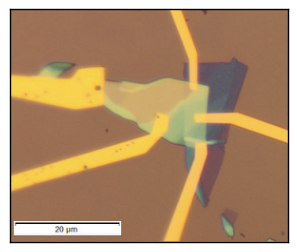

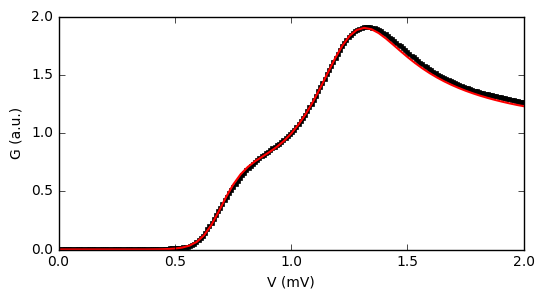

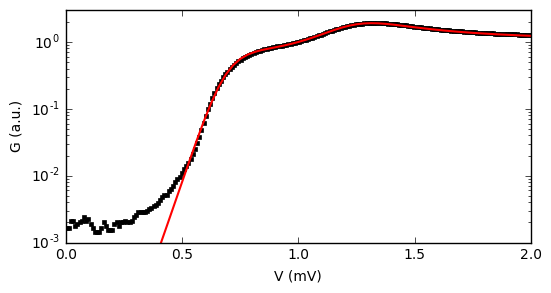

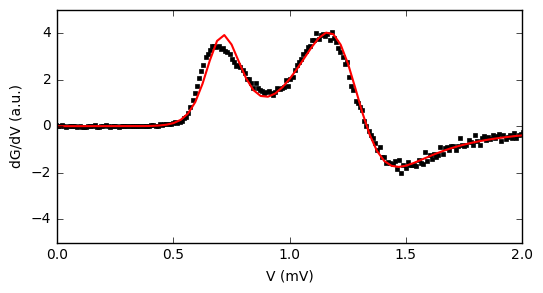

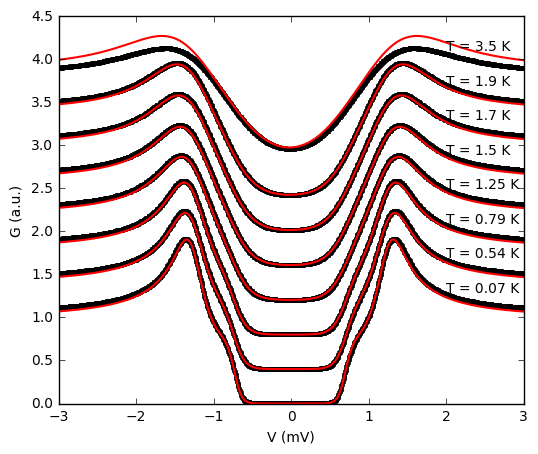

In [5]:


f,axes = plt.subplots(1)
f.set_size_inches(6, 3)
img = mpimg.imread('device_scale.png')
axes.imshow(img)
axes.axes.get_xaxis().set_visible(False)
axes.axes.get_yaxis().set_visible(False)

V, G, Gasym = LoadandSymmetrizeTemp(1,0.125)
T = Tempdata.transpose()[6]/0.08
Delta01 = Tempdata.transpose()[0]
Delta02 = Tempdata.transpose()[1]

f,axes = plt.subplots(1)
f.set_size_inches(6, 3)
params = makeParamaters(Tempdata[0])
Delta0 = [params['Delta01'].value, params['Delta02'].value]
Gamma = [params['Gamma1'].value, params['Gamma2'].value]
Neff = [params['Neff1'].value, params['Neff2'].value]
T = params['T'].value
Vs = numpy.linspace(min(V),max(V),300)
I = IofV(Vs,Delta0,Gamma,Neff,T)
axes.plot(V,G ,color = 'black',label = 'data',marker = 's',markersize = 3,linewidth = 0)
axes.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
axes.set_xlim([0, 2])
axes.set_xlabel('V (mV)')
axes.set_ylabel('G (a.u.)')


f,axes = plt.subplots(1)
f.set_size_inches(6, 3)
params = makeParamaters(Tempdata[0])
Delta0 = [params['Delta01'].value, params['Delta02'].value]
Gamma = [params['Gamma1'].value, params['Gamma2'].value]
Neff = [params['Neff1'].value, params['Neff2'].value]
T = params['T'].value
Vs = numpy.linspace(min(V),max(V),300)
I = IofV(Vs,Delta0,Gamma,Neff,T)
axes.plot(V,G ,color = 'black',label = 'data',marker = 's',markersize = 3,linewidth = 0)
axes.plot(Vs[0:len(Vs)-1],numpy.diff(I)/numpy.diff(Vs),'r',linewidth=1.5,label = 'fit')
axes.set_xlim([0, 2])
axes.set_ylim([1e-3,3])
axes.set_yscale('log')
axes.set_xlabel('V (mV)')
axes.set_ylabel('G (a.u.)')


f,axes = plt.subplots(1)
f.set_size_inches(6, 3)
axes.plot(V[1:len(V)],numpy.diff(G)/numpy.diff(V),color = 'black',label = 'data',marker = 's',\
     markersize = 2.5,linewidth = 0)
axes.plot(Vs[1:len(Vs)-1],numpy.diff(I,2)/(numpy.diff(Vs[1:len(Vs)])**2),'r',linewidth=1.5,label = 'fit')
axes.set_xlim([0, 2])
axes.set_xlabel('V (mV)')
axes.set_ylabel('dG/dV (a.u.)')

f,axes = plt.subplots(1)
f.set_size_inches(6, 5)
for k in range(1,9):
    V, G, Gasym = LoadandSymmetrizeTemp(k,0.125)
    LoadFitPlotG(axes,V,G,makeParamaters(Tempdata[k-1]),[-3,3],False,(k-1)*0.4)
    axes.annotate('T = {} K'.format(Tsample[k-1]),xy = (2,1.3+(k-1)*0.4))


# axarr[1,1].plot(T,Delta01,label = '$\Delta_L$',marker = 's',\
#              markersize = 6,linewidth = 0)
# axarr[1,1].plot(T,Delta02,label = '$\Delta_S$',marker = 's',\
#              markersize = 6,linewidth = 0)
# axarr[1,1].set_xlabel('$T_{fit} $ (K)')
# axarr[1,1].set_ylabel('$\Delta $ (eV)')
# temp = axarr[1,1].legend()

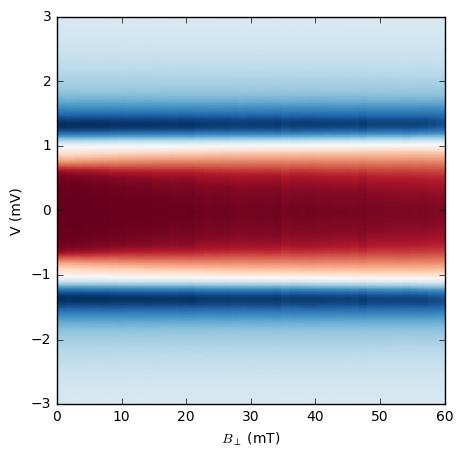

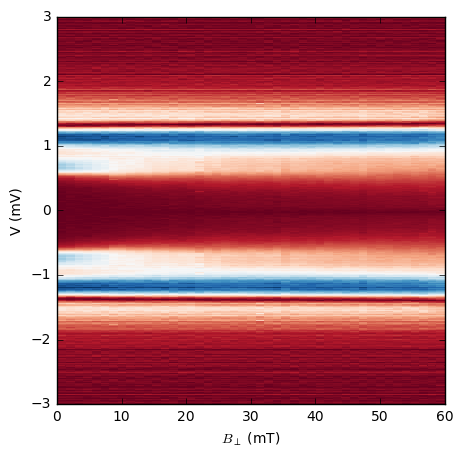

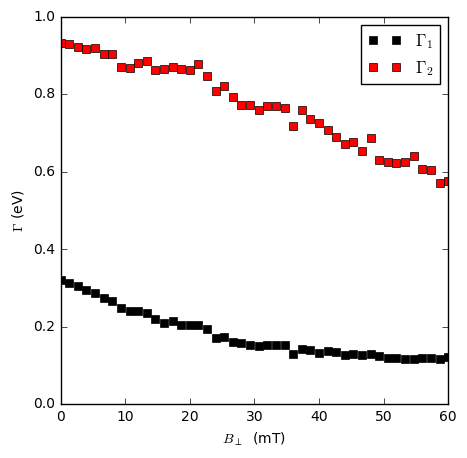

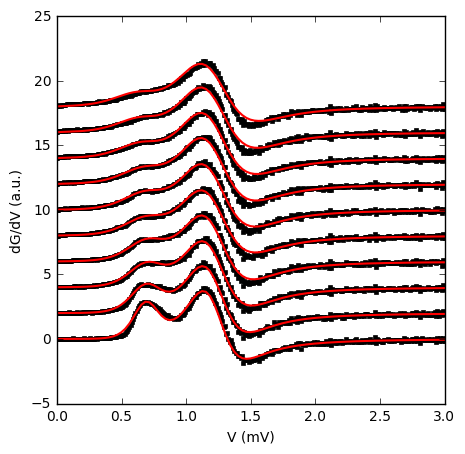

In [6]:
f,axes = plt.subplots(1)
f.set_size_inches(5, 5)
axes.pcolor(Bs_perp,Vs_perp,Gs_perp,cmap = 'RdBu')
axes.set_ylim([-3,3])
axes.set_xlabel('$B_\perp$ (mT)')
axes.set_ylabel('V (mV)')


f,axes = plt.subplots(1)
f.set_size_inches(5, 5)
axes.pcolor((Bs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1],\
           (Vs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1],\
           abs((dGdVs_perp[:][0:46].transpose())[:][0:Vs_perp.shape[1]-1]),cmap='RdBu')
axes.set_ylim([-3,3])
axes.set_xlabel('$B_\perp$ (mT)')
axes.set_ylabel('V (mV)')

f,axes = plt.subplots(1)
f.set_size_inches(5, 5)
axes.plot(PerB,(numpy.flipud(PerFieldData).transpose())[2],color = 'black',label = '$\Gamma_1$',marker = 's',\
             markersize = 6,linewidth = 0)
axes.plot(PerB,(numpy.flipud(PerFieldData).transpose())[3],color = 'red',label = '$\Gamma_2$',marker = 's',\
             markersize = 6,linewidth = 0)
axes.set_xlabel('$B_\perp$  (mT)') 
axes.set_ylabel('$\Gamma$ (eV)')
axes.set_ylim([0,1])
axes.legend()



f,axes = plt.subplots(1)
f.set_size_inches(5, 5)
for k in range(46,0,-5):
    V, G, Gasym= LoadandSymmetrizePerField(k,-0.035)
    LoadFitPlotdGdV(axes,V,G,makeParamaters(PerFieldData[46-k]),[0,3],(46-k)*0.4)



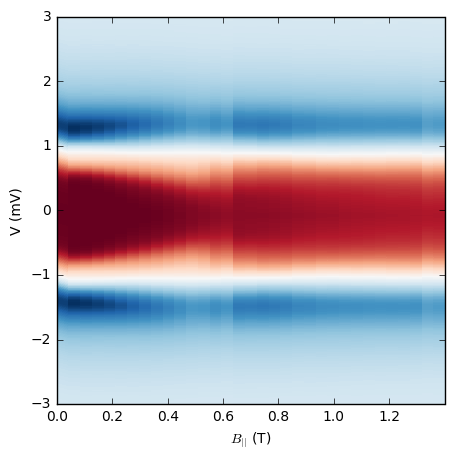

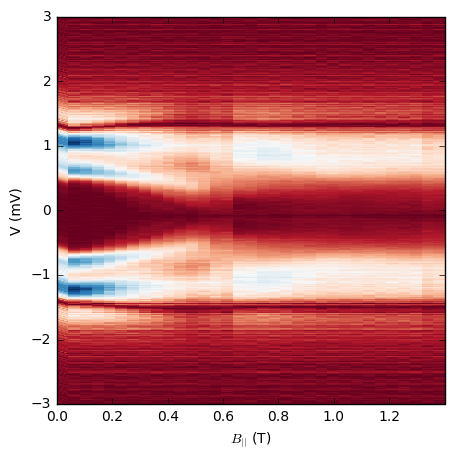

In [48]:
f,axes = plt.subplots(1)
f.set_size_inches(5, 5)

axes.pcolor(Bs_par,Vs_par,Gs_par,cmap = 'RdBu')
axes.set_ylim([-3,3])
axes.set_xlim([0,1.4])
axes.set_xlabel('$B_{||}$ (T)')
axes.set_ylabel('V (mV)')

f,axes = plt.subplots(1)
f.set_size_inches(5, 5)


axes.pcolor((Bs_par.transpose())[:][0:Vs_par.shape[1]-1],\
           (Vs_par.transpose())[:][0:Vs_par.shape[1]-1],\
           abs(dGdVs_par.transpose()),\
          cmap='RdBu')
axes.set_ylim([-3,3])
axes.set_xlim([0,1.4])
axes.set_xlabel('$B_{||}$ (T)')
axes.set_ylabel('V (mV)')

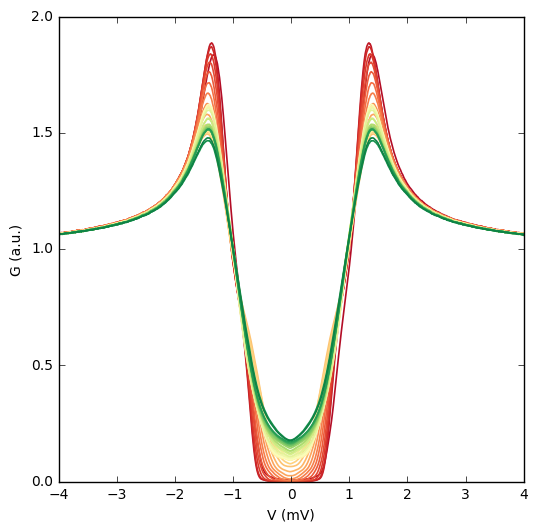

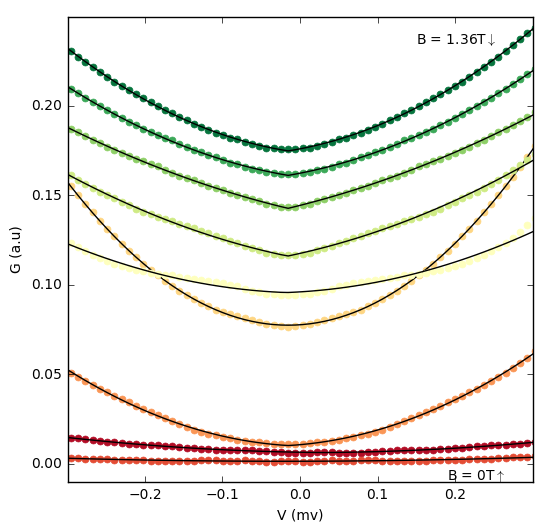

In [50]:
f,axes = plt.subplots(1)
f.set_size_inches(6, 6)
for k in range(1,len(ParB)):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    axes.plot(V,G,linewidth = 1.2,color = plt.cm.RdYlGn(k/35))
axes.set_xlim([-4,4])
axes.set_xlabel('V (mV)')
axes.set_ylabel('G (a.u.)')

f,axes = plt.subplots(1)
f.set_size_inches(6, 6)
for k in range(1,34,4):
    V, G, Gasym, B = LoadandSymmetrizeParField(k,0.025)
    MinIndex = numpy.argmin(abs(V+0.4))
    MaxIndex = numpy.argmin(abs(V-0.4))
    V = V[MinIndex:MaxIndex]
    G = G[MinIndex:MaxIndex]
    a = ParFieldLinFit_0p3[k-1][0]
    b = ParFieldLinFit_0p3[k-1][1]
    c = ParFieldLinFit_0p3[k-1][2]
    V0 = ParFieldLinFit_0p3[k-1][3]
    axes.plot(V,G,marker = '.',linewidth = 0,markersize = 10,color = plt.cm.RdYlGn(k/34))
    axes.plot(V,a*(V-V0)**2+b*abs((V-V0))+c,color = 'black',linewidth = 1)
axes.set_xlim([-0.3,0.3])
axes.set_ylim([-0.01,0.25])
axes.set_xlabel('V (mv)')
axes.set_ylabel('G (a.u)')
axes.annotate('B = 0T$\\uparrow$',xy = (0.19,-0.009))
axes.annotate('B = 1.36T$\downarrow$',xy = (0.15,0.235))



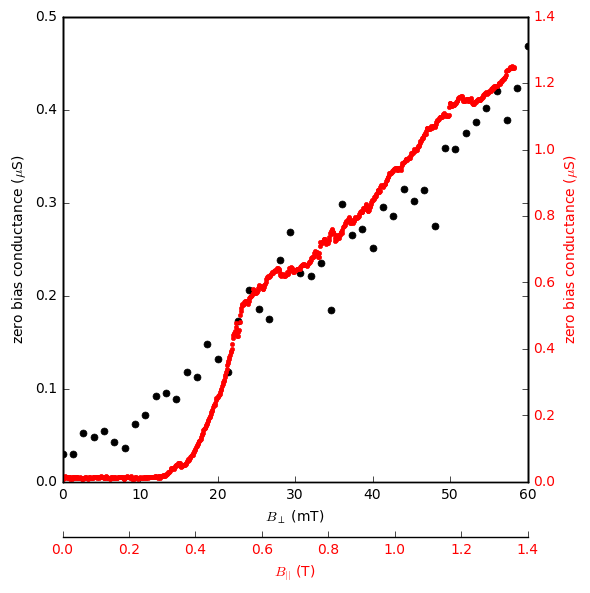

In [47]:
f,axes = plt.subplots(1)
f.set_size_inches(6, 6)

bigdata = scipy.io.loadmat('summary-data.mat')
G0 = bigdata['CondPerpField'][0][0][0][0][0][0]
axes.set_xlabel('$B_\perp$ (mT)')
axes.set_ylabel('zero bias conductance ($\mu$S)')
axes.plot(PerB,G0,color = 'black',linewidth = 0,marker = '.',markersize = 10)

bigdata = scipy.io.loadmat('summary-data.mat')
data = bigdata['CondParField'][0][0][0][0][0][0].transpose()
B = data[1]
G0 = data[2]
axtemp2 = axes.twiny()
axtemp2.set_xlabel('$B_{||}$ (T)')
axtemp2.set_xlim([0,1.4])
for tl in axtemp2.get_xticklabels():
    tl.set_color('r')
axtemp2.xaxis.label.set_color('red')
axtemp2.tick_params(axis='x', labelcolor='red')

axtemp2.xaxis.set_ticks_position('bottom')
axtemp2.xaxis.set_label_position('bottom')
axtemp2.spines['bottom'].set_position(('outward', 40))


axtemp = axtemp2.twinx()
axtemp.plot(B[0:800],G0[0:800],color = 'red',linewidth = 0,marker = '.')

axtemp.yaxis.label.set_color('red')
axtemp.tick_params(axis='y', labelcolor='red')
temp = axtemp.set_ylabel('zero bias conductance ($\mu$S)')

